In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from statistics import mean
from tabulate import tabulate
import seaborn as sns

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/datasets_csv/final_data.csv')

In [3]:
cleaned_data = data.drop(['Unnamed: 0','dob','driverId','constructorId','date','DNF (Constructor Fault)', 'DNF (Driver Error)','DNF','Constructor Win',
                                   'circuitId','Country','Race Position'], axis=1)

In [4]:
season = 2017
data_season= cleaned_data[cleaned_data['year']<(season+1)]

encoder = LabelEncoder()
data_season['Grand Prix Name'] = encoder.fit_transform(data_season['Grand Prix Name'])
data_season['Constructor Name'] = encoder.fit_transform(data_season['Constructor Name'])
data_season['Driver Name'] = encoder.fit_transform(data_season['Driver Name'])
data_season['Driver Nationality'] = encoder.fit_transform(data_season['Driver Nationality'])
data_season['Constructor Nationality'] = encoder.fit_transform(data_season['Constructor Nationality'])


data_test = data_season[data_season['year']==season]
data_train = data_season[data_season['year']<season]

X = data_train.drop('Driver Win',axis=1)
y = data_train['Driver Win']
X_test = data_test.drop('Driver Win',axis=1)
y_test = data_test['Driver Win']

<ipython-input-4-28b8b2baa01b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_season['Grand Prix Name'] = encoder.fit_transform(data_season['Grand Prix Name'])
<ipython-input-4-28b8b2baa01b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_season['Constructor Name'] = encoder.fit_transform(data_season['Constructor Name'])
<ipython-input-4-28b8b2baa01b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [5]:
#Balancing our dataset with oversampling to avoid lossing information and taking into account that the dataset is not huge

# rus = RandomUnderSampler(random_state=42)
# X_res, y_res = rus.fit_resample(X, y)
# print('Resampled dataset shape %s' % Counter(y_res))

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

**Score Function**:
Taking into account that the predictions should be done by races and the models more often than not predict several winners or no winner for the races, a scoring fuction is defined. This function considered the winner as the driver with the highest probability of winning the race. The precision_score function will give the score for each individual round and the scoring fucntion will get the mean value of the precisions_scores of the entire season.

In [6]:
def scoring_scaled(model):

  data_score = data_test.copy()
  score_pre = []
  score_f1 = []
  score_roc_auc = []
  score_recall = []

  for round in  data_score[data_score['year']==season]['round']:


    data_event = data_score[( data_score['year']==season) & ( data_score['round']==round)]
    X_test_1 = data_event.drop('Driver Win',axis=1)
    y_test = data_event['Driver Win']

    X_test_event = pd.DataFrame(scaler.transform(X_test_1), columns = X_test_1.columns)

    probability = model.predict_proba(X_test_event)

    X_score_event = X_test_event.copy()
    X_score_event['Probability'] = probability[:,1]
    X_score_event['Actual Win'] = y_test.reset_index(drop = True)
    X_score_event = X_score_event.sort_values(by = 'Probability', ascending = False)
    X_score_event.reset_index(inplace = True, drop = True)
    X_score_event ['predicted'] = X_score_event['Probability']
    max = X_score_event ['predicted'].max()
    X_score_event ['predicted'] = X_score_event ['predicted'].apply(lambda x: 1  if x==max else 0)
    score_pre.append(precision_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_f1.append(f1_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_recall.append(recall_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_roc_auc.append(roc_auc_score(X_score_event['Actual Win'], X_score_event['Probability']))

  score_pre_model = mean(score_pre)
  score_f1_model = mean(score_f1)
  score_roc_auc_model = mean(score_roc_auc)
  score_recall_model = mean(score_recall)
  print('training.........')

  return(score_pre_model, score_recall_model, score_f1_model, score_roc_auc_model)



In [7]:
def scoring(model):

  data_score = data_test.copy()
  score_pre = []
  score_f1 = []
  score_roc_auc = []
  score_recall = []

  for round in  data_score[data_score['year']==season]['round']:


    data_event = data_score[( data_score['year']==season) & ( data_score['round']==round)]
    X_test_1 = data_event.drop('Driver Win',axis=1)
    y_test = data_event['Driver Win']

    probability = model.predict_proba(X_test_1)

    X_score_event = X_test_1.copy()
    X_score_event['Probability'] = probability[:,1]
    X_score_event['Actual Win'] = y_test
    X_score_event = X_score_event.sort_values(by = 'Probability', ascending = False)
    X_score_event.reset_index(inplace = True, drop = True)
    X_score_event ['predicted'] = X_score_event['Probability']
    max = X_score_event ['predicted'].max()
    X_score_event ['predicted'] = X_score_event ['predicted'].apply(lambda x: 1  if x==max else 0)
    score_pre.append(precision_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_f1.append(f1_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_recall.append(recall_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_roc_auc.append(roc_auc_score(X_score_event['Actual Win'], X_score_event['Probability']))

  score_pre_model = mean(score_pre)
  score_f1_model = mean(score_f1)
  score_roc_auc_model = mean(score_roc_auc)
  score_recall_model = mean(score_recall)
  print('training.........')

  return(score_pre_model, score_recall_model, score_f1_model, score_roc_auc_model)

**Testing Algorithms on 2017 season**

In [8]:
scaler = StandardScaler()
X_res_scaled = pd.DataFrame(scaler.fit_transform(X_res), columns = X_res.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [20]:
#knn
knn = KNeighborsClassifier(n_neighbors = 50, weights = 'uniform').fit(X_res_scaled,y_res)
score_knn = scoring_scaled(knn)[0]

training.........


In [21]:
#Logistic Regression
lr = LogisticRegression(penalty = 'l1', solver = 'saga', C = 0.0215443469003188).fit(X_res_scaled,y_res)
score_lr = scoring_scaled(lr)[0]

training.........


In [22]:
#SVC
svc = SVC(kernel = 'rbf', gamma = 0.1, C = 0.031622777, probability=True).fit(X_res_scaled,y_res)
score_svc = scoring_scaled(svc)[0]

training.........


In [23]:
#RandomForest Model
RF = RandomForestClassifier(n_estimators = 500, max_depth = 5, max_features = 5, random_state=0).fit(X_res,y_res)
score_RF = scoring(RF)[0]

training.........


In [24]:
#Gradient Boosting Decision Trees
GBDT = GradientBoostingClassifier(n_estimators = 2200, max_depth = 3, learning_rate = 0.01, random_state = 0).fit(X_res,y_res)
score_GBDT = scoring(GBDT)[0]

training.........


In [25]:
#Neural Networks
nn = MLPClassifier(hidden_layer_sizes = [10,10,10,10], activation = 'tanh', solver = 'adam',alpha = 1, random_state = 0).fit(X_res_scaled,y_res)
score_nn = scoring_scaled(nn)[0]

training.........


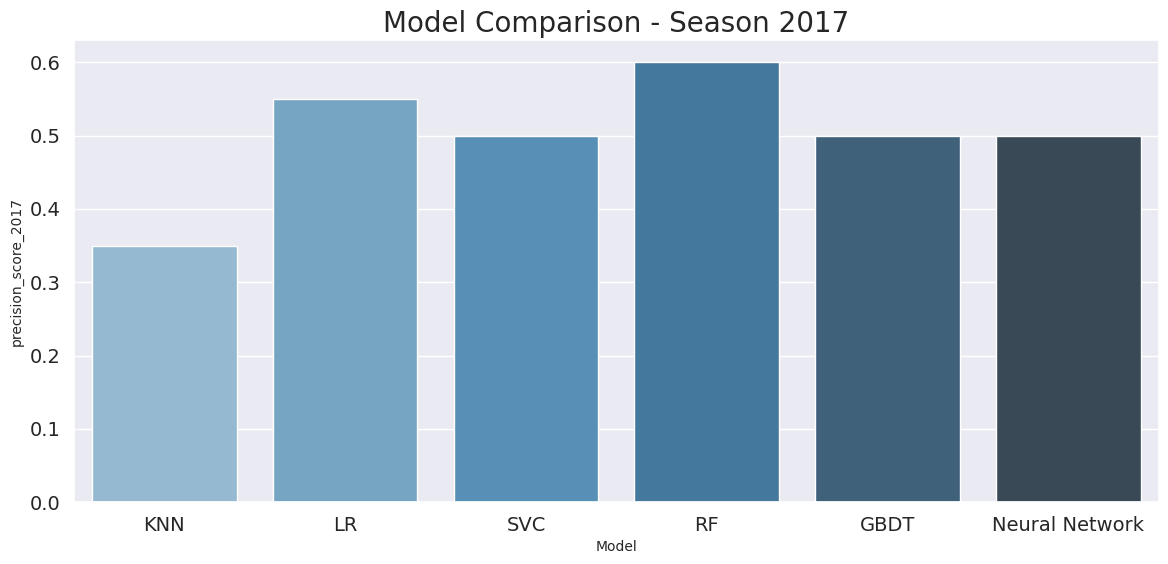

In [31]:
results_data_training = [['KNN', score_knn],
                         ['LR', score_lr],
                         ['SVC', score_svc],
                         ['RF', score_RF],
                         ['GBDT', score_GBDT],
                         ['Neural Network', score_nn]]

results_data_training_df = pd.DataFrame(results_data_training, columns = ['Model', 'precision_score_2017'])

results_data_training_df.to_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/Results_csv/test_2017.csv', index=False, header=True)

ax = sns.barplot(x = results_data_training_df.Model, y = results_data_training_df.precision_score_2017, palette=("Blues_d"))
sns.set_context("poster")

sns.set(rc={'figure.figsize':(14,6)})
plt.xlabel('Model', fontsize=10);
plt.ylabel('precision_score_2017', fontsize=10);
plt.title('Model Comparison - Season 2017', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)